## 1.1：basic data clean(TCGA.PRAD.sampleMap_HumanMethylation450 named PRAD_Methylation_Levels.csv and PRAD_Methylation_Levels_Missing_Value_Statistics.csv)

In [ ]:
import pandas as pd
import numpy as np
import os

# Set input and output paths
input_file = '/Users/yangqingdi/Desktop/M-28/NTU_DATA/TCGA.PRAD.sampleMap_HumanMethylation450'
output_dir = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED'
stats_output = os.path.join(output_dir, 'PRAD_Methylation_Levels_Missing_Value_Statistics.csv')
cleaned_output = os.path.join(output_dir, 'PRAD_Methylation_Levels.csv')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Processing file: {input_file}")

# Read data file using whitespace separator (raw string to avoid SyntaxWarning)
data = pd.read_csv(input_file, sep='\s+')

# 1. Rename the 'sample' column to 'Probe_ID'
# Check if the first column is named 'sample'
if data.columns[0] == 'sample':
    data.rename(columns={'sample': 'Probe_ID'}, inplace=True)
else:
    # If the first column is not 'sample', still rename it to 'Probe_ID'
    data.rename(columns={data.columns[0]: 'Probe_ID'}, inplace=True)
    print(f"Note: The first column name is '{data.columns[0]}' instead of 'sample', renamed to 'Probe_ID'")

print(f"Data dimensions: {data.shape[0]} rows x {data.shape[1]} columns")
print(f"Column names: {list(data.columns)}")

# Ensure all columns except 'Probe_ID' are numeric
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# 2. Analyze missing values
total_rows = len(data)
# Count number of missing values in each row (excluding Probe_ID)
missing_counts = data.iloc[:, 1:].isnull().sum(axis=1)
# Calculate the percentage of missing values per row
missing_percentages = (missing_counts / (data.shape[1] - 1)) * 100

# Classify rows based on percentage of missing values
missing_stats = {
    '0%': sum(missing_percentages == 0),
    '0-30%': sum((missing_percentages > 0) & (missing_percentages <= 30)),
    '30-50%': sum((missing_percentages > 30) & (missing_percentages <= 50)),
    '50-80%': sum((missing_percentages > 50) & (missing_percentages <= 80)),
    '80-100%': sum(missing_percentages > 80)
}

# Calculate the percentage of each class over the total rows
missing_stats_percentage = {k: (v / total_rows) * 100 for k, v in missing_stats.items()}

# Create statistics DataFrame
stats_df = pd.DataFrame({
    'Missing_Value_Range': list(missing_stats.keys()),
    'Row_Count': list(missing_stats.values()),
    'Percentage_of_Total': [missing_stats_percentage[k] for k in missing_stats.keys()]
})

# Save statistics to CSV
stats_df.to_csv(stats_output, index=False)
print(f"Missing value statistics saved to {stats_output}")

# Print missing value distribution
print("\nMissing value distribution:")
for k, v in missing_stats.items():
    print(f"{k}: {v} rows ({missing_stats_percentage[k]:.2f}%)")

# 3. Drop rows with any missing values
data_cleaned_missing = data.dropna()
print(f"Number of rows before removing missing values: {len(data)}")
print(f"Number of rows after removing missing values: {len(data_cleaned_missing)}")

# 4. Remove outliers (values outside the 0-1 range)
# Create a mask for values within 0-1 range
in_range_mask = (data_cleaned_missing.iloc[:, 1:] >= 0) & (data_cleaned_missing.iloc[:, 1:] <= 1)
# Keep only rows where all values are in the valid range
valid_rows_mask = in_range_mask.all(axis=1)
data_cleaned_final = data_cleaned_missing[valid_rows_mask]

print(f"Number of rows after removing outliers: {len(data_cleaned_final)}")

# Save cleaned data
data_cleaned_final.to_csv(cleaned_output, index=False)
print(f"Cleaned data saved to {cleaned_output}")

# Print summary
print("\nData cleaning summary:")
print(f"Total number of rows in original data: {total_rows}")
print(f"Number of rows removed due to missing values: {total_rows - len(data_cleaned_missing)}")
print(f"Number of rows removed due to outliers: {len(data_cleaned_missing) - len(data_cleaned_final)}")
print(f"Final number of cleaned data rows: {len(data_cleaned_final)}")


Processing file: /Users/yangqingdi/Desktop/M-28/NTU_DATA/TCGA.PRAD.sampleMap_HumanMethylation450


FileNotFoundError: [Errno 2] No such file or directory: '/Users/yangqingdi/Desktop/M-28/NTU_DATA/TCGA.PRAD.sampleMap_HumanMethylation450'

## 1.2 TOIL_RSEM_TPM_LUAD.csv named LUAD_TOIL_RSEM_TPM_Levels.csv and PRAD_TOIL_RSEM_TPM_Missing_Value_Statistics.csv

In [ ]:
import pandas as pd
import numpy as np
import os

# Set the input and output paths
input_file = 'TOIL_RSEM_TPM_LUAD.csv'
output_dir = 'NTU_DATA_CLEANED'
stats_output = os.path.join(output_dir, 'LUAD_TOIL_RSEM_TPM_Missing_Value_Statistics.csv')
cleaned_output = os.path.join(output_dir, 'LUAD_TOIL_RSEM_TPM_Levels.csv')

# Create output directory (if it does not exist)
os.makedirs(output_dir, exist_ok=True)

print(f"file: {input_file}")

# Read CSV file - set keep_default_na = True to ensure that all standard NaN values are recognized
# Also set na_values to contain multiple possible missing value representations
try:
    data = pd.read_csv(input_file, header=None, 
                        keep_default_na=True,
                        na_values=['NA', 'N/A', 'nan', '', ' ', '#N/A', '#VALUE!', 'NULL', 'null', 'NaN'])
    print(f": {data.shape}")
except Exception as e:
    print(f" {e}")
    exit(1)

# print top 5 rows

print(data.head(5))

#Use the first row as the column name
data.columns = data.iloc[0]

# Keep the data from the second row
data = data.iloc[1:].reset_index(drop=True)

# Rename the first and second columns
old_columns = list(data.columns)
new_columns = old_columns.copy()

# Check and rename the first column
if pd.isna(new_columns[0]) or new_columns[0] == '':
    print("The first column name is empty, rename it to 'Ensembl_ID'")
    new_columns[0] = 'Ensembl_ID'
else:
    print(f"the first row name is '{new_columns[0]}', rename it to 'Ensembl_ID'")
    new_columns[0] = 'Ensembl_ID'

# Look and rename the second column
if new_columns[1] != 'HGNC_Symbol':
    print(f"The second column name is'{new_columns[1]}', rename it to'HGNC_Symbol'")
    new_columns[1] = 'HGNC_Symbol'
else:
    print("The second column is already 'HGNC_Symbol'")

# Update column name
data.columns = new_columns

print("The column name is set:")
print(list(data.columns[:5]), "...")

# Analyze missing values before data type conversion - the first missing value check
print("\n===== Missing value analysis before data conversion =====")
missing_before_conversion = data.isnull().sum().sum()
print(f"Total number of missing values before data type conversion: {missing_before_conversion}")

rows_with_missing_before = data.isnull().any(axis=1).sum()
print(f"The number of rows containing missing values before data type conversion: {rows_with_missing_before}")

# View data that is not missing but could cause problems
print("\nCheck for special data values...")
for col in data.columns[2:]:
    try:
        # Try to convert a column to a numeric type and count how many values there are that cannot be converted
        pd.to_numeric(data[col], errors='raise')
    except:
        non_numeric = []
        for value in data[col].dropna().unique():
            try:
                float(value)
            except:
                non_numeric.append(value)
        
        if non_numeric:
            print(f"column'{col}' include {len(non_numeric)} data type:")
            print(non_numeric[:5]) 

# Now convert the presentation data column to numeric type, recording the missing value changes before and after the conversion
na_counts_before = data.isna().sum(axis=1)

# Convert data type
for col in data.columns[2:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# The converted missing value
na_counts_after = data.isna().sum(axis=1)
new_na_rows = (na_counts_after > na_counts_before).sum()

print(f"\nThe number of rows of missing values added during data conversion: {new_na_rows}")
missing_after_conversion = data.isnull().sum().sum()
print(f"Total number of missing values after data type conversion: {missing_after_conversion}")
print(f"New missing values added during conversion: {missing_after_conversion - missing_before_conversion}")

# missing value analysis
total_rows = len(data)
missing_counts = data.iloc[:, 2:].isnull().sum(axis=1)
missing_percentages = (missing_counts / (data.shape[1] - 2)) * 100

# Rows are categorized by percentage of missing values
missing_stats = {
    '0%': sum(missing_percentages == 0),
    '0-30%': sum((missing_percentages > 0) & (missing_percentages <= 30)),
    '30-50%': sum((missing_percentages > 30) & (missing_percentages <= 50)),
    '50-80%': sum((missing_percentages > 50) & (missing_percentages <= 80)),
    '80-100%': sum(missing_percentages > 80)
}

# Validate missing value classification
print("\nMissing value distribution verification:")
print(f"sum of rows: {sum(missing_stats.values())}")
print(f"total rows: {total_rows}")

# Calculate the percentage of the total number of rows
missing_stats_percentage = {k: (v / total_rows) * 100 for k, v in missing_stats.items()}

# Create a statistics box
stats_df = pd.DataFrame({
    'Missing_Value_Range': list(missing_stats.keys()),
    'Row_Count': list(missing_stats.values()),
    'Percentage_of_Total': [missing_stats_percentage[k] for k in missing_stats.keys()]
})

# Print missing value distribution
print("\nMissing value distribution:")
for k, v in missing_stats.items():
    print(f"{k}: {v}行 ({missing_stats_percentage[k]:.2f}%)")

# Save statistics to CSV
stats_df.to_csv(stats_output, index=False)
print(f"Missing value statistics are saved to {stats_output}")

# Deletes rows that contain missing values
data_cleaned = data.dropna()
rows_removed = len(data) - len(data_cleaned)
print(f"\nThe number of rows before deleting missing values: {len(data)}")
print(f"The number of rows after deleting missing values: {len(data_cleaned)}")
print(f"The number of rows deleted: {rows_removed} ({(rows_removed/len(data))*100:.2f}%)")

# Save the cleaned data
data_cleaned.to_csv(cleaned_output, index=False)
print(f"The cleaned data is saved to {cleaned_output}")

# Print summary information
print("\n===== Data cleansing summary =====")
print(f"Total number of rows of raw data: {total_rows}")
print(f"The number of rows containing missing values: {(missing_counts > 0).sum()}")
print(f"Number of rows deleted {rows_removed}")
print(f"Number of data rows after final cleaning: {len(data_cleaned)}")
print(f"The number of rows in the final data that contain missing values: {data_cleaned.isnull().any(axis=1).sum()}")

# Double check that the distribution of missing values is as expected
if missing_stats['0%'] == total_rows and rows_removed > 0:
    print("\nWarning: Potential problem detected!")

处理文件: /Users/heweilin/Desktop/M-28/NTU_DATA/TOIL_RSEM_TPM_PRAD.csv


/var/folders/6r/vh9hm9y50sng_kp683fc7t8m0000gn/T/ipykernel_28130/895779353.py:19: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,2

成功读取数据，形状: (56405, 497)
查看数据前5行:
               0            1             2             3             4    \
0              NaN  HGNC_symbol  TCGA_EJ_7125  TCGA_CH_5751  TCGA_KK_A7B3   
1  ENSG00000000003       TSPAN6        5.7498         4.986        4.5614   
2  ENSG00000000005         TNMD        -3.816       -5.0116        -3.816   
3  ENSG00000000419         DPM1        4.7704        5.0233        4.8064   
4  ENSG00000000457        SCYL3        2.2543        2.4753        2.1988   

            5             6             7             8             9    ...  \
0  TCGA_EJ_8468  TCGA_ZG_A8QW  TCGA_J4_A83K  TCGA_ZG_A9MC  TCGA_HC_7742  ...   
1        5.0348        5.5056         5.436        4.7693        5.5239  ...   
2        -3.458       -9.9658        0.7058       -5.0116        0.8408  ...   
3        5.5583        5.0909        4.9668         5.101        5.1281  ...   
4        3.1924        2.1047        2.9966        2.6185        2.8877  ...   

            487        

## 2.1：The data table generated Mir-related methylation expression file named PRAD_MIR100HG_Methylation_Levels.csv

In [ ]:
import pandas as pd

# read methylation data
methylation_data = pd.read_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_Methylation_Levels.csv")

# Read CpG probe information
probe_map = pd.read_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA/probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy", sep='\t')

# The CpG sites associated with MIR100HG were extracted
mir100hg_probes = probe_map[probe_map['gene'].str.contains('MIR100HG', case=False, na=False)]
mir100hg_probe_ids = mir100hg_probes['#id'].tolist()

# Sift through the data on these sites in methylation
mir100hg_methylation = methylation_data[methylation_data['Probe_ID'].isin(mir100hg_probe_ids)]

# Save the original filtered data
mir100hg_methylation.to_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Methylation_Levels.csv", index=False)

# Build probe_map_subset and change the column name for later merge
probe_map_subset = mir100hg_probes.rename(columns={'#id': 'CpG_Site'})

# Read the methylation table
meth_table = pd.read_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Methylation_Levels.csv")

# Merge: Press CpG_Site to add genomic location information
meth_table_annotated = meth_table.merge(
    probe_map_subset[['CpG_Site', 'chromStart', 'chromEnd']],
    left_on='Probe_ID',
    right_on='CpG_Site',
    how='left'
)

# Delete redundant CpG_Site columns
meth_table_annotated = meth_table_annotated.drop(columns=['CpG_Site'])

# Move chromStart and chromEnd to Probe_ID
cols = meth_table_annotated.columns.tolist()
new_order = ['Probe_ID', 'chromStart', 'chromEnd'] + [col for col in cols if col not in ['Probe_ID', 'chromStart', 'chromEnd']]
meth_table_annotated = meth_table_annotated[new_order]

# View the column name confirmation sequence
print(meth_table_annotated.columns)

# Replace the column name chromStart → Chrom_Start, chromEnd → Chrom_End
meth_table_annotated = meth_table_annotated.rename(columns={
    "chromStart": "Chrom_Start",
    "chromEnd": "Chrom_End"
})
print(meth_table_annotated.columns)

# Save the final result to the specified path
meth_table_annotated.to_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Methylation_Levels.csv", index=False)


Index(['Probe_ID', 'chromStart', 'chromEnd', 'TCGA-G9-6343-01',
       'TCGA-KK-A8IA-01', 'TCGA-KK-A6E4-01', 'TCGA-EJ-AB20-01',
       'TCGA-H9-7775-01', 'TCGA-XJ-A9DX-01', 'TCGA-KK-A6E6-01',
       ...
       'TCGA-EJ-7312-01', 'TCGA-V1-A8MM-01', 'TCGA-EJ-A65F-01',
       'TCGA-G9-6498-01', 'TCGA-EJ-5505-01', 'TCGA-CH-5761-11',
       'TCGA-HC-8261-01', 'TCGA-XQ-A8TB-01', 'TCGA-G9-6329-01',
       'TCGA-EJ-5496-01'],
      dtype='object', length=552)
Index(['Probe_ID', 'Chrom_Start', 'Chrom_End', 'TCGA-G9-6343-01',
       'TCGA-KK-A8IA-01', 'TCGA-KK-A6E4-01', 'TCGA-EJ-AB20-01',
       'TCGA-H9-7775-01', 'TCGA-XJ-A9DX-01', 'TCGA-KK-A6E6-01',
       ...
       'TCGA-EJ-7312-01', 'TCGA-V1-A8MM-01', 'TCGA-EJ-A65F-01',
       'TCGA-G9-6498-01', 'TCGA-EJ-5505-01', 'TCGA-CH-5761-11',
       'TCGA-HC-8261-01', 'TCGA-XQ-A8TB-01', 'TCGA-G9-6329-01',
       'TCGA-EJ-5496-01'],
      dtype='object', length=552)


## 2.2：The data table generated Mir-related methylation expression files, which were grouped and named PRAD_MIR100HG_Methylation_High_Low.csv.

In [ ]:
import pandas as pd

# read file
df = pd.read_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Methylation_Levels.csv")
import pandas as pd

# Separate the meta information columns (assuming the first 3 columns are Probe_ID, Chrom_Start, Chrom_End)
meta_cols = ['Probe_ID', 'Chrom_Start', 'Chrom_End']
sample_cols = [col for col in df.columns if col not in meta_cols]

# Create a new DataFrame to store in long format
long_df = df.melt(
    id_vars=['Probe_ID'], 
    value_vars=sample_cols, 
    var_name='Patient_ID', 
    value_name='Methylation_Value'
)

# Merge the median of each Probe and compare the high and low
median_per_probe = df[sample_cols].median(axis=1)
median_map = dict(zip(df['Probe_ID'], median_per_probe))

# Add a High/Low tag column
long_df['Group'] = long_df.apply(
    lambda row: 'High' if row['Methylation_Value'] > median_map[row['Probe_ID']] else 'Low',
    axis=1
)

long_df.to_csv("/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Methylation_High_Low.csv", index=False)

 ## 2.3：Data tables generate patient information named PRAD_TCGA_Patient_Survival_Info.csv数据来源： Survival_SupplementalTable_S1_20171025_xena_sp

In [ ]:
import pandas as pd
import numpy as np
print('imported')
# Load the survival supplemental table
file_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA/Survival_SupplementalTable_S1_20171025_xena_sp"
methylation_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Methylation_Levels.csv"
output_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_TCGA_Patient_Survival_Info.csv"
df_survival = pd.read_csv(file_path, sep="\t")
# Check shape of Survival_Supplemental table
print(df_survival.shape)
# Read patients of methylated table header (read only the first row)
with open(methylation_path, 'r') as f:
    header_line = f.readline().strip()

# Extract sample ID (except the first column Probe_ID)
sample_ids = header_line.split(',')[1:]

# Extract patient ID (first 12 digits)
patient_ids_from_methylation = [s[:12] for s in sample_ids]
# Select common patients
df_common = df_survival[df_survival['_PATIENT'].isin(patient_ids_from_methylation)]
#check common patients
df_common

# Select and rename the desired field
df_selected = df_common[[
    '_PATIENT',
    'OS.time',
    'OS',
    'age_at_initial_pathologic_diagnosis',
    'gender',
    'ajcc_pathologic_tumor_stage',
    'treatment_outcome_first_course',
    'histological_type'
]].copy()

df_selected['OS'] = df_selected['OS'].map({0: 'Alive', 1: 'Dead'})

df_selected.rename(columns={
    '_PATIENT': 'Patient ID',
    'OS.time': 'Survival Time (days)',
    'OS': 'Survival Status',
    'age_at_initial_pathologic_diagnosis': 'Age',
    'gender': 'Gender',
    'ajcc_pathologic_tumor_stage': 'Cancer Stage',
    'treatment_outcome_first_course': 'Treatment Outcome',
    'histological_type': 'Histological Type'
}, inplace=True)
# save result file
df_selected.to_csv(output_path, index=False)
print(f"successfully generated：{output_path}")
# Read the generated file
df_result = pd.read_csv(output_path)

# Look at the first few lines of data
print("\n result head：")
print(df_result.head())

# check data shape
print(f"\nresult data shape：{df_result.shape[0]} rows, {df_result.shape[1]} columns")

# Check the number of missing values per column
print("\n number of missing value：")
print(df_result.isnull().sum())


imported
(12591, 34)
successfully generated：/Users/heweilin/Desktop/M-28/NTU_DATA_CLEANED/PRAD_TCGA_Patient_Survival_Info.csv

 result head：
     Patient ID  Survival Time (days) Survival Status   Age Gender  \
0  TCGA-2A-A8VL                 621.0           Alive  51.0   MALE   
1  TCGA-2A-A8VO                1701.0           Alive  57.0   MALE   
2  TCGA-2A-A8VT                1373.0           Alive  47.0   MALE   
3  TCGA-2A-A8VV                 671.0           Alive  52.0   MALE   
4  TCGA-2A-A8VX                1378.0           Alive  70.0   MALE   

   Cancer Stage Treatment Outcome                    Histological Type  
0           NaN               NaN  Prostate Adenocarcinoma Acinar Type  
1           NaN               NaN  Prostate Adenocarcinoma Acinar Type  
2           NaN     [Discrepancy]  Prostate Adenocarcinoma Acinar Type  
3           NaN               NaN  Prostate Adenocarcinoma Acinar Type  
4           NaN               NaN  Prostate Adenocarcinoma Acinar Type  


 ## 2.4：The data table generated MIR gene expression information named PRAD_MIR100HG_Expression_Levels.csv

In [ ]:
import pandas as pd
import os

# Set file path
file_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_TOIL_RSEM_TPM_Levels.csv"
output_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Expression_Levels.csv"

# Read presentation data
df = pd.read_csv(file_path)

# check column
if "HGNC_Symbol" not in df.columns:
    raise ValueError("Missing 'HGNC_Symbol' column!")

# Extract MIR100HG
mir100hg_data = df[df["HGNC_Symbol"] == "MIR100HG"]

# Extract sample expression values (starting from column 3)
tpm_columns = df.columns[2:]
mir100hg_expression = mir100hg_data[tpm_columns].T
mir100hg_expression.columns = ["MIR100HG_Expression"]
mir100hg_expression["Patient_ID"] = mir100hg_expression.index

# Calculate the median and label it
median_val = mir100hg_expression["MIR100HG_Expression"].median()
mir100hg_expression["Group"] = mir100hg_expression["MIR100HG_Expression"].apply(
    lambda x: "High" if x >= median_val else "Low"
)

# Add the Probe_ID column
mir100hg_expression["Probe_ID"] = "MIR100HG"

# Adjust column order
final_df = mir100hg_expression[["Probe_ID", "Patient_ID", "MIR100HG_Expression", "Group"]]

# save CSV
final_df.to_csv(output_file, index=False)

print("Export complete:")
print(output_file)
print(f"Total number of derived samples {final_df.shape[0]}")
print(f"High :{(final_df['Group'] == 'High').sum()},Low ：{(final_df['Group'] == 'Low').sum()}")


✅ 导出完成！文件路径：
/Users/heweilin/Desktop/M-28/NTU_DATA_CLEANED/PRAD_MIR100HG_Expression_Levels.csv
共导出样本数：495
High 表达：248，Low 表达：247


 ### 2.4.2：plot

imported


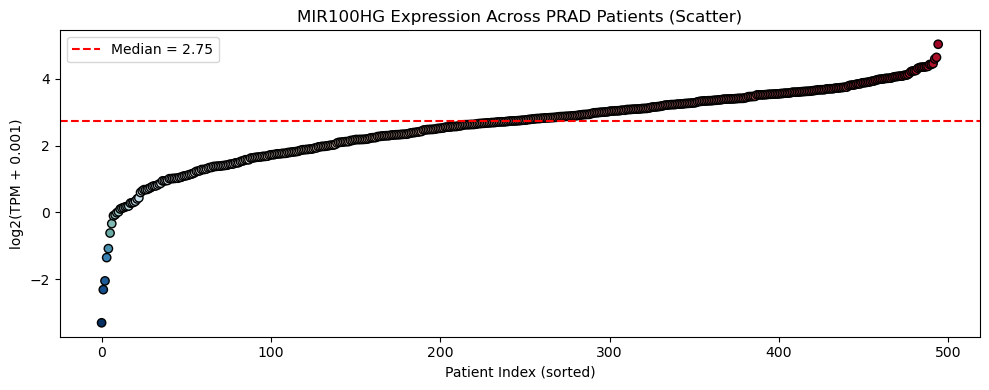

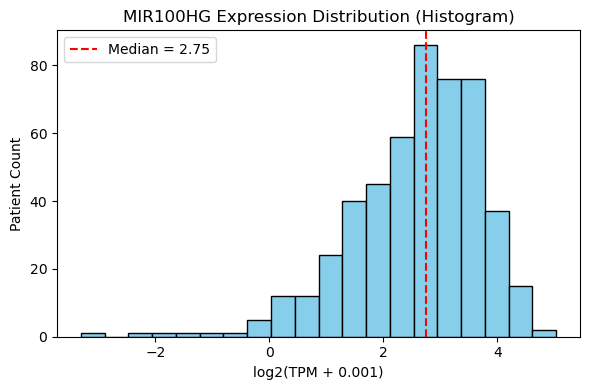

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create Nature Blue and Red colormap
nature_colors = [
    "#053061", "#134b87", "#327db7", "#6fafa2", "#c7e0ed", "#ffffff",
    "#fbd2bc", "#ea8b88", "#b71c2c", "#a00624"
]
nature_cmap = LinearSegmentedColormap.from_list("nature_blue_red", nature_colors, N=256)
import os
print("imported")
# Reload PAAD expression data
file_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/PRAD_TOIL_RSEM_TPM_Levels.csv"
df = pd.read_csv(file_path)

# Ensure required column is present
if "HGNC_Symbol" not in df.columns:
    raise ValueError("Column 'HGNC_Symbol' not found in the dataset!")
    # Transpose expression data
mir100hg_expression = mir100hg_data[tpm_columns].T
mir100hg_expression.columns = ['MIR100HG_Expression']
mir100hg_expression['Patient_ID'] = mir100hg_expression.index
mir100hg_expression = mir100hg_expression.reset_index(drop=True)

# Sort for plotting
mir100hg_expression_sorted = mir100hg_expression.sort_values(by='MIR100HG_Expression').reset_index(drop=True)
mir100hg_median = mir100hg_expression_sorted['MIR100HG_Expression'].median()

# Scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(
    x=mir100hg_expression_sorted.index,
    y=mir100hg_expression_sorted['MIR100HG_Expression'],
    c=mir100hg_expression_sorted['MIR100HG_Expression'],  
    cmap=nature_cmap,
    edgecolors='k'
)
plt.axhline(y=mir100hg_median, color='red', linestyle='--', label=f"Median = {mir100hg_median:.2f}")
plt.title("MIR100HG Expression Across PRAD Patients (Scatter)")
plt.xlabel("Patient Index (sorted)")
plt.ylabel("log2(TPM + 0.001)")
plt.legend()
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(6, 4))
plt.hist(mir100hg_expression_sorted['MIR100HG_Expression'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=mir100hg_median, color='red', linestyle='--', label=f"Median = {mir100hg_median:.2f}")
plt.title("MIR100HG Expression Distribution (Histogram)")
plt.xlabel("log2(TPM + 0.001)")
plt.ylabel("Patient Count")
plt.legend()
plt.tight_layout()
plt.show()